In [4]:
import numpy as np
import os
import pandas as pd
import math
result_pd=pd.DataFrame()
cov_list=[]
F1score_list=[]
type_list=[]
method_list=[]
db=['quanttb','tbprof']
#db=['quanttb']

P_R_table_Quanttb=np.zeros((4,6))
P_R_table_tbprof=np.zeros((4,6))
coverage_prop=['10x','20x','90x-10x','70x-30x']
#coverage_prop=['90x-10x','70x-30x']
for d in db:
    for c in coverage_prop:
        coverage=c
        db_type=d
        dir="../scripts/finaloutput/art_"+coverage+"_"+db_type+"_rerun/"
        #os.chdir(dir)
        file_path = dir+"config.txt"

        with open(file_path, "r") as file:
            line = file.readline()
            integer_strings = line.split()
            integers = [int(i) for i in integer_strings]
        #print(integers)
        m=integers[0]
        K=integers[1]
        V=integers[2]
        
        filename = dir+'n_m_z0.dat'
        fileobj = open(filename, mode='r')
        n_m_z = np.fromfile(fileobj, dtype=np.uint32)
        fileobj.close
        n_m_z=n_m_z.reshape((m,K))
        theta=n_m_z/n_m_z.sum(axis=1)[:,None]
        theta=np.around(theta,2)
        '''
        theta=pd.read_csv(dir+'Prior.csv').values
        '''
        print("coverage:",c)
        cov_list.append(c)
        cov_list.append(c)
        type_list.append(db_type)
        type_list.append(db_type)
        method_list.append('QuantTB')
        F1score_list.append(cal_F1_quanttb(c))
        method_list.append('Demixer')
        F1score_list.append(cal_F1_demixer(c))
        
result_pd['coverage']=cov_list
result_pd['Database']=type_list
result_pd['Method']=method_list
result_pd['F1 score']=F1score_list

coverage: 10x
F1 score 0.9852717291741677
F1score: 0.908741441402914
coverage: 20x
F1 score 0.9863803766242786
F1score: 0.9935467257263947
coverage: 90x-10x
F1 score 0.9940239043824701
F1score: 0.9874512548745155
coverage: 70x-30x
F1 score 0.995019920318725
F1score: 0.994950504949508
coverage: 10x
F1 score 0.8700768477707226
F1score: 0.9089471932026238
coverage: 20x
F1 score 0.8811339152764144
F1score: 0.9334896526480125
coverage: 90x-10x
F1 score 0.8799627689367735
F1score: 0.9520770810051754
coverage: 70x-30x
F1 score 0.8807947019867554
F1score: 0.9483871835285714


/data/users/CS18D017/miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2 in image.
/data/users/CS18D017/miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: Figure_4b.svg


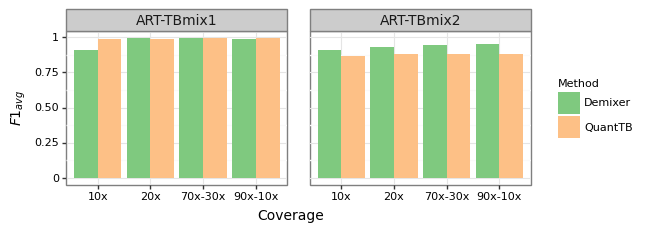

In [5]:
import matplotlib.pylab as plt
from plotnine import *
import plotnine as p9
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
#custom_colors=["#8856a7", "#9ebcda"]
#custom_colors =["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728"]
custom_colors=["#7fc97f","#fdc086"]
#ggtitle("Simulated Data")+
result_pd['Database']=result_pd['Database'].replace('tbprof','ART-TBmix2')
result_pd['Database']=result_pd['Database'].replace('quanttb','ART-TBmix1')

g=ggplot(result_pd,aes(x='coverage',y='F1 score', fill = 'Method'))+\
    scale_fill_manual(values = custom_colors)+\
    geom_bar(stat = "summary", position="dodge")+facet_grid('.~Database',scales = "free", space = "free")+theme_bw()+\
    p9.theme(subplots_adjust={'wspace':0.10})+p9.theme(figure_size=(6, 2),axis_text=element_text(color='black'))+\
    p9.theme(axis_text_x = element_text(size = 8),axis_text_y = element_text(size = 8),axis_title_y = element_text(size = 10),axis_title_x = element_text(size = 10),strip_text = element_text(size = 10),legend_text = element_text(size = 8),legend_title = element_text(size = 8),plot_title = element_text(size = 10))+\
    p9.theme(axis_title_y=element_text(weight='bold'))+labs(x = "Coverage")+\
    p9.labs(y='$F1_{avg}$')
g.draw()


#dir="/data/users/CS18D017/LVM_Multistrain/Preprocessing/Pycode/Demixer-main/Demixer-main/Figures"
#os.chdir(dir)
ggsave(plot=g, filename='Figure_4b.svg', dpi=300)

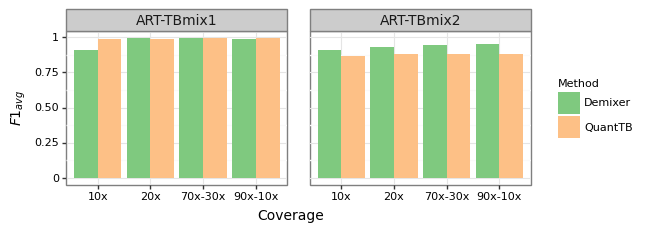

<ggplot: (8764514234597)>

In [6]:
g

In [2]:
def cal_F1_demixer(c):
    #dir='../scripts/finaloutput/tbprof_20x/'
    #theta=pd.read_csv(dir+'Prior.csv').values
    sample_id=pd.read_csv(dir+'Sample_id.csv')
    strain_names=pd.read_csv('simulation2/strain_names_'+db_type+'_coverage_'+coverage+'.txt',delimiter=' ',header=None)
    #diverg_id=list(pd.read_csv(dir+"subset.csv").columns)
    diverg_id=list(pd.read_csv(dir+"diverg_id.csv")['0'])
    TP=[]
    FP=[]
    FN=[]
    Precision=[]
    Recall=[]
    F1score=[]
    if(db_type=="quanttb"):
        st=0
    else:
        st=7
        
    lineage=pd.read_csv(dir+'lineage.csv')    
    for i in range(1,201):
        ind=sample_id[sample_id['Sample_id']=='sample_'+str(i)].index[0]
        strain_ind=strain_names[strain_names[0]==i].index[0]
        strains=np.where(theta[ind]>0)[0]      
        #print(strains)
        detected_strains=[]
        '''
        for j in strains:
            detected_strains.append(diverg_id[j])
        
        
        #else:
        #print(strain_ind)
        '''
        detected_strains=lineage.iloc[ind-1,:].values
        detected_strains=[x for x in detected_strains if str(x).lower() != 'nan']
        #print(i,detected_strains)
        
        #         detected_strains.append('d')
        if('-' in c):  #70x-30x or 90x-10x
            if(strain_names.iloc[strain_ind,1][st:]==strain_names.iloc[strain_ind,2][st:]):
                actual_strains=[strain_names.iloc[strain_ind,1][st:]]
            else:
                actual_strains=[strain_names.iloc[strain_ind,1][st:],strain_names.iloc[strain_ind,2][st:]]
        else:          #10x #20x
            actual_strains=[strain_names.iloc[strain_ind,1][st:],strain_names.iloc[strain_ind,2][st:],strain_names.iloc[strain_ind,3][st:],strain_names.iloc[strain_ind,4][st:]]
        #print(i,detected_strains,actual_strains)
        TP.append(len(set(detected_strains)&set(actual_strains)))
        FN.append(len(actual_strains)-len(set(detected_strains)&set(actual_strains)))
        FP.append(len(detected_strains)-len(set(detected_strains)&set(actual_strains)))
        
        #print(detected_strains,actual_strains)
        Precision.append((TP[i-1]+0.0001)/((TP[i-1]+0.0001)+(FP[i-1]+0.0001)))
        Recall.append((TP[i-1]+0.0001)/((TP[i-1]+0.0001)+(FN[i-1]+0.0001)))
        F1score.append(2*(Precision[i-1]*Recall[i-1])/(Precision[i-1]+Recall[i-1]))
        ind=coverage_prop.index(c)
        if(db_type=="quanttb"):
            
            P_R_table_Quanttb[ind][0]=sum(Precision)/len(Precision)
            P_R_table_Quanttb[ind][1]=sum(Recall)/len(Recall)
            P_R_table_Quanttb[ind][2]=sum(F1score)/len(F1score)
        else:
            
            P_R_table_tbprof[ind][0]=sum(Precision)/len(Precision)
            P_R_table_tbprof[ind][1]=sum(Recall)/len(Recall)
            P_R_table_tbprof[ind][2]=sum(F1score)/len(F1score)
            
    print("F1score:",sum(F1score)/len(F1score))
    return sum(F1score)/len(F1score)
    

In [3]:
def cal_F1_quanttb(c):
    topic_id= pd.read_csv('simulation2/'+db_type+'_coverage_'+coverage+'.csv', delimiter=',', names=list(range(11)))
    strain_names=pd.read_csv('simulation2/strain_names_'+db_type+'_coverage_'+coverage+'.txt',delimiter=' ',header=None)


    TP=[]
    FP=[]
    FN=[]
    Precision=[]
    Recall=[]
    F1score=[]
    for i in range(1,201):
        #print(topic_id[topic_id[0]=='art_'+str(i)])
        detected_strains=[]
        actual_strains=[]

        if(len(topic_id[topic_id[0]=='art_'+str(i)])>0):
            ind=topic_id[topic_id[0]=='art_'+str(i)].index[0]
            strain_ind=strain_names[strain_names[0]==i].index[0]
            
            l=list(topic_id.iloc[ind,1:].values)
            
            #print(strain_names.iloc[strain_ind,:])
            
            for j in l:
                if(str(j)==j ):
                    detected_strains.append(j)
            if('-' in c):
                actual_strains=[strain_names.iloc[strain_ind,1],strain_names.iloc[strain_ind,2]]
            else:
                actual_strains=[strain_names.iloc[strain_ind,1],strain_names.iloc[strain_ind,2],strain_names.iloc[strain_ind,3],strain_names.iloc[strain_ind,4]]
        #print(detected_strains,actual_strains)

        TP.append(len(set(detected_strains)&set(actual_strains)))
        FN.append(len(actual_strains)-len(set(detected_strains)&set(actual_strains)))
        FP.append(len(detected_strains)-len(set(detected_strains)&set(actual_strains)))
        #print(i,ind,TP[i-1],FP[i-1],FN[i-1],detected_strains,actual_strains)
        Precision.append((TP[i-1]+0.01)/((TP[i-1]+FP[i-1])+0.01))
        Recall.append((TP[i-1]+0.01)/((TP[i-1]+FN[i-1])+0.01))
        F1score.append(2*(Precision[i-1]*Recall[i-1])/(Precision[i-1]+Recall[i-1]))
        ind=coverage_prop.index(c)
        if(db_type=="quanttb"):
            
            P_R_table_Quanttb[ind][3]=sum(Precision)/len(Precision)
            P_R_table_Quanttb[ind][4]=sum(Recall)/len(Recall)
            P_R_table_Quanttb[ind][5]=sum(F1score)/len(F1score)
        else:
            
            P_R_table_tbprof[ind][3]=sum(Precision)/len(Precision)
            P_R_table_tbprof[ind][4]=sum(Recall)/len(Recall)
            P_R_table_tbprof[ind][5]=sum(F1score)/len(F1score)
    print("F1 score",sum(F1score)/len(F1score))
    return sum(F1score)/len(F1score)

In [11]:
P_R_table_Quanttb=np.around(P_R_table_Quanttb,3)
#np.savetxt('BenchmarkQuanttbdataset.csv', P_R_table_Quanttb, delimiter=',')

In [12]:
P_R_table_tbprof=np.around(P_R_table_tbprof,3)
#np.savetxt('Benchmarktbprofdataset.csv', P_R_table_tbprof, delimiter=',')

In [1]:
actual_strains=['R1','R2','R3','R6']
detected_strains=['R1','R2','R3','R4','R5']
len(detected_strains)-len(set(detected_strains)&set(actual_strains))

2

In [13]:
P_R_table_Quanttb

array([[0.913, 0.906, 0.909, 0.976, 0.998, 0.985],
       [0.995, 0.992, 0.994, 0.978, 0.998, 0.986],
       [0.987, 0.987, 0.987, 0.99 , 1.   , 0.994],
       [0.995, 0.995, 0.995, 0.992, 1.   , 0.995]])